In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# -------------------------------
# Settings and Hyperparameters
# -------------------------------
m = 100            # number of sensor points (and collocation x values)
P = 100            # number of boundary points per sample
Q = 100            # number of collocation points per sample (here, Q = m)
N_train = 10000    # number of training input functions
D_val = 0.01       # diffusion coefficient
k_val = 1.0        # reaction coefficient

# -------------------------------
# 1. Generate Training Input Functions u(x)
# -------------------------------
# (Assume a Gaussian Random Field sampler; here we use a simple placeholder.)
# For a real GRF, one could use gstools or similar.
def sample_grf(num_points, num_functions, length_scale=0.2, var=3.0, seed=1234):
    np.random.seed(seed)
    # Here we use a simple RBF covariance to generate samples.
    x_grid = np.linspace(0, 1, num_points)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    cov = var * np.exp(-((X1 - X2)**2) / (2*length_scale**2))
    # For simplicity, we generate independent normals at each sensor.
    # (This is not a proper GRF, but serves as a placeholder.)
    U = np.random.randn(num_points, num_functions)
    return x_grid, U  # U shape: (m, N_train)

x, U = sample_grf(m, N_train, length_scale=0.2)
# U_data: each sample is a row vector (u(x) evaluated at m sensors)
U_data = torch.tensor(U.T, dtype=torch.float32)  # shape: (N_train, m)

# -------------------------------
# 2. Define the PI-DeepONet Model
# -------------------------------
class DeepONet(nn.Module):
    def __init__(self, m, hidden_dim=50, num_layers=5, trunk_input_dim=2):
        """
        m: number of sensor points (dimension of u)
        trunk_input_dim: dimension of the trunk input (here, 2 for (x,t))
        """
        super(DeepONet, self).__init__()
        self.m = m
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Branch network: input dimension = m, output dimension = hidden_dim.
        layers_branch = []
        in_dim = m
        for i in range(num_layers - 1):
            layers_branch.append(nn.Linear(in_dim, hidden_dim))
            layers_branch.append(nn.Tanh())
            in_dim = hidden_dim
        layers_branch.append(nn.Linear(in_dim, hidden_dim))
        self.branch_net = nn.Sequential(*layers_branch)
        
        # Trunk network: input dimension = trunk_input_dim (here 2), output dimension = hidden_dim.
        layers_trunk = []
        in_dim = trunk_input_dim
        for i in range(num_layers - 1):
            layers_trunk.append(nn.Linear(in_dim, hidden_dim))
            layers_trunk.append(nn.Tanh())
            in_dim = hidden_dim
        layers_trunk.append(nn.Linear(in_dim, hidden_dim))
        self.trunk_net = nn.Sequential(*layers_trunk)
        
        # Learnable bias
        self.bias = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, u, xt):
        """
        u: tensor of shape (B, m) --- input function samples.
        xt: tensor of shape (B, num_query, 2) --- query points (x,t).
        Returns: tensor of shape (B, num_query) --- network output.
        """
        B, num_query, _ = xt.shape
        branch_out = self.branch_net(u)  # shape: (B, hidden_dim)
        
        # Evaluate trunk net: flatten xt from (B, num_query, 2) -> (B*num_query, 2)
        trunk_in = xt.view(-1, 2)
        trunk_out = self.trunk_net(trunk_in)  # shape: (B*num_query, hidden_dim)
        trunk_out = trunk_out.view(B, num_query, self.hidden_dim)  # (B, num_query, hidden_dim)
        
        # Dot product between branch and trunk outputs:
        # Expand branch_out: (B, 1, hidden_dim) then multiply with trunk_out and sum along hidden_dim.
        s = torch.sum(branch_out.unsqueeze(1) * trunk_out, dim=2) + self.bias  # shape: (B, num_query)
        return s



In [ ]:
# Instantiate the model and send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# -------------------------------
# 3. Helper Functions for Sampling Points
# -------------------------------
def sample_boundary_points(B, P):
    """
    For each sample (B), sample P points on the boundary of [0,1]x[0,1]
    (enforcing zero initial and spatial-boundary conditions).
    We sample from three parts:
      - initial condition: t = 0, x ~ U(0,1)
      - left boundary: x = 0, t ~ U(0,1)
      - right boundary: x = 1, t ~ U(0,1)
    """
    P1 = P // 3
    P2 = P // 3
    P3 = P - P1 - P2  # to account for remainders
    
    # Initial: t=0
    x_init = torch.rand(B, P1, 1)
    t_init = torch.zeros(B, P1, 1)
    bc_init = torch.cat([x_init, t_init], dim=2)  # (B, P1, 2)
    
    # Left boundary: x=0
    x_left = torch.zeros(B, P2, 1)
    t_left = torch.rand(B, P2, 1)
    bc_left = torch.cat([x_left, t_left], dim=2)
    
    # Right boundary: x=1
    x_right = torch.ones(B, P3, 1)
    t_right = torch.rand(B, P3, 1)
    bc_right = torch.cat([x_right, t_right], dim=2)
    
    boundary_points = torch.cat([bc_init, bc_left, bc_right], dim=1)  # shape: (B, P, 2)
    return boundary_points

def sample_collocation_points(B, sensor_x):
    """
    For each sample, we use the sensor grid for the spatial coordinate and sample a time in [0,1].
    sensor_x: tensor of shape (m, 1) --- the fixed sensor locations.
    Returns: collocation points of shape (B, m, 2) with
             first column = sensor_x (repeated), second column = random t.
    """
    m = sensor_x.shape[0]
    collocation_x = sensor_x.unsqueeze(0).repeat(B, 1, 1)  # (B, m, 1)
    collocation_t = torch.rand(B, m, 1, device=device)  # (B, m, 1) sampled uniformly in [0,1]
    collocation_points = torch.cat([collocation_x, collocation_t], dim=2)  # (B, m, 2)
    return collocation_points

# -------------------------------
# 4. Define Loss Functions
# -------------------------------
def operator_loss(model, u_batch, boundary_points):
    """
    Enforces zero initial and boundary conditions:
      Gθ(u)(x,t) should be zero on the boundary.
    boundary_points: tensor of shape (B, P, 2)
    """
    s_boundary = model(u_batch, boundary_points)  # shape: (B, P)
    loss_op = torch.mean(s_boundary**2)
    return loss_op

def physics_loss(model, u_batch, sensor_x):
    """
    Enforces the PDE residual at collocation points.
    For each sample, we set spatial collocation points as sensor_x (of shape (m,1))
    and sample a time coordinate.
    Computes R = s_t - D * s_xx - k * s^2, and penalizes (R - u(x))^2.
    """
    B = u_batch.size(0)
    # Generate collocation points: (B, m, 2)
    collocation_points = sample_collocation_points(B, sensor_x)
    # Make sure collocation_points requires grad (to compute derivatives)
    collocation_points = collocation_points.clone().detach().requires_grad_(True)
    
    # Evaluate network output s = Gθ(u)(x,t) at collocation points.
    s = model(u_batch, collocation_points)  # shape: (B, m)
    
    # --- Compute time derivative s_t ---
    # We sum s to get a scalar and differentiate wrt collocation_points.
    s_sum = s.sum()
    grad_all = torch.autograd.grad(s_sum, collocation_points, create_graph=True)[0]
    # grad_all has shape (B, m, 2); the second coordinate (index 1) is the derivative wrt t.
    s_t = grad_all[..., 1]  # (B, m)
    
    # --- Compute second spatial derivative s_xx ---
    # First derivative wrt x (index 0)
    s_x = grad_all[..., 0]  # (B, m)
    s_x_sum = s_x.sum()
    grad_sx = torch.autograd.grad(s_x_sum, collocation_points, create_graph=True)[0]
    s_xx = grad_sx[..., 0]  # (B, m)
    
    # PDE residual: R = s_t - D * s_xx - k * s^2
    R = s_t - D_val * s_xx - k_val * s**2  # (B, m)
    
    # The forcing term is u(x), which for each sample is given in u_batch.
    # (Assuming the sensor ordering in u_batch matches sensor_x.)
    loss_phys = torch.mean((R - u_batch)**2)
    return loss_phys

def total_loss(model, u_batch, sensor_x, boundary_points):
    L_op = operator_loss(model, u_batch, boundary_points)
    L_phys = physics_loss(model, u_batch, sensor_x)
    return L_op + L_phys

# -------------------------------
# 5. Prepare DataLoader and Training Setup
# -------------------------------
batch_size = 10000  # choose a batch size (you can adjust this)
train_dataset = TensorDataset(U_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# sensor_x: fixed spatial sensor locations (m, 1)
sensor_x = torch.tensor(x, dtype=torch.float32).view(m, 1)


model = DeepONet(m=m, hidden_dim=50, num_layers=5, trunk_input_dim=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.9**(epoch//10000))
# Optional: you can also add a learning rate scheduler if desired.

# -------------------------------
# 6. Training Loop
# -------------------------------
epochs = 120000
train_losses = []

for epoch in range(epochs):
    model.train()
    loss_epoch = 0.0
    for (u_batch,) in train_loader:
        B = u_batch.size(0)
        u_batch = u_batch.to(device)  # shape: (B, m)
        
        # Sample boundary points for this batch: shape (B, P, 2)
        boundary_points = sample_boundary_points(B, P).to(device)
        
        optimizer.zero_grad()
        loss_val = total_loss(model, u_batch, sensor_x.to(device), boundary_points)
        loss_val.backward()
        optimizer.step()
        loss_epoch += loss_val.item()
    
    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)
    if epoch % 100 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:5d} | Loss: {loss_epoch:.6f} | LR: {current_lr:.6e}")

Using device: cuda
Epoch     0 | Loss: 1.008437 | LR: 1.000000e-03
Epoch   100 | Loss: 0.984773 | LR: 1.000000e-03
Epoch   200 | Loss: 0.984414 | LR: 1.000000e-03
Epoch   300 | Loss: 0.983664 | LR: 1.000000e-03
Epoch   400 | Loss: 0.982105 | LR: 1.000000e-03
Epoch   500 | Loss: 0.976604 | LR: 1.000000e-03


KeyboardInterrupt: 

Solving PDE for test sample 100/1000
Solving PDE for test sample 200/1000
Solving PDE for test sample 300/1000
Solving PDE for test sample 400/1000
Solving PDE for test sample 500/1000
Solving PDE for test sample 600/1000
Solving PDE for test sample 700/1000
Solving PDE for test sample 800/1000
Solving PDE for test sample 900/1000
Solving PDE for test sample 1000/1000


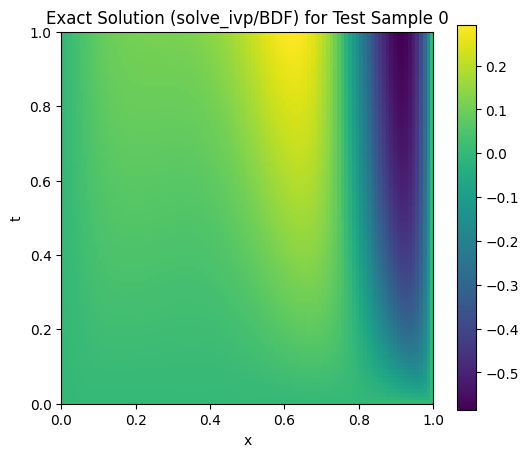

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -------------------------------
# Settings and Hyperparameters
# -------------------------------
m = 100          # number of spatial grid points (x in [0,1])
n_t = 100        # number of time points (t in [0,1])
N_test = 1000    # number of test functions
D_val = 0.01     # diffusion coefficient
k_val = 1.0      # reaction coefficient

dx = 1.0 / (m - 1)   # spatial step size

# -------------------------------
# 1. GRF Sampler for u(x)
# -------------------------------
def sample_grf(num_points, num_functions, length_scale=0.2, var=3.0, seed=2025):
    np.random.seed(seed)
    x_grid = np.linspace(0, 1, num_points)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    cov = var * np.exp(-((X1 - X2)**2) / (2 * length_scale**2))
    L = np.linalg.cholesky(cov + 1e-6 * np.eye(num_points))
    U = []
    for _ in range(num_functions):
        z = np.random.randn(num_points)
        u = L @ z
        U.append(u)
    U = np.array(U)  # shape: (num_functions, num_points)
    return x_grid, U

# Generate test forcing functions: U_test has shape (N_test, m)
x_grid, U_test = sample_grf(m, N_test, length_scale=0.2, var=3.0, seed=2025)

# -------------------------------
# 2. Define the ODE RHS for the PDE (Method of Lines)
# -------------------------------
def pde_rhs(t, s, u, D, k, dx):
    """
    s: vector of interior values (length m-2)
    u: full forcing function (length m)
    Returns: ds/dt for interior nodes (length m-2)
    """
    m = len(u)
    # Reconstruct full solution with boundary conditions (s[0]=0, s[m-1]=0)
    s_full = np.zeros(m)
    s_full[1:-1] = s  # interior nodes
    # Compute second derivative using central differences
    s_xx = (s_full[2:] - 2 * s_full[1:-1] + s_full[:-2]) / dx**2
    # Compute time derivative for interior nodes: s_t = D*s_xx + k*(s)^2 + u(x)
    dsdt = D * s_xx + k * s_full[1:-1]**2 + u[1:-1]
    return dsdt

# -------------------------------
# 3. Solve the PDE for a single u(x) using solve_ivp (BDF method)
# -------------------------------
def solve_pde(u, D, k, m, n_t, dx, t_span=(0, 1)):
    # Initial condition for interior nodes (length m-2)
    s0 = np.zeros(m - 2)
    # Define the desired time points
    t_eval = np.linspace(t_span[0], t_span[1], n_t)
    # Request dense output so we can evaluate at exactly t_eval
    sol = solve_ivp(
        pde_rhs, 
        t_span, 
        s0, 
        method='BDF', 
        t_eval=t_eval, 
        args=(u, D, k, dx),
        dense_output=True
    )
    # Evaluate the solution at t_eval; sol.sol returns an array of shape (m-2, n_t)
    s_dense = sol.sol(t_eval)
    # Reconstruct the full solution (including boundaries, which are zero)
    S = np.zeros((n_t, m))
    S[:, 1:-1] = s_dense.T  # Transpose so that S has shape (n_t, m)
    return S


# -------------------------------
# 4. Generate the Test Dataset (Parallelizable)
# -------------------------------
# For demonstration, we generate solutions for the first few test cases.
# In practice, you can loop over all N_test cases or use parallel computing.
S_test = []
for i in range(N_test):
    if (i+1) % 100 == 0:
        print(f"Solving PDE for test sample {i+1}/{N_test}")
    u_sample = U_test[i]  # shape: (m,)
    S = solve_pde(u_sample, D_val, k_val, m, n_t, dx)
    S_test.append(S)
S_test = np.array(S_test)  # shape: (N_test, n_t, m)

# -------------------------------
# 5. Visualization for a Test Sample
# -------------------------------
i_sample = 0  # index of test sample to visualize
S_exact_sample = S_test[i_sample]  # shape: (n_t, m)

plt.figure(figsize=(6, 5))
plt.imshow(S_exact_sample, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title("Exact Solution (solve_ivp/BDF) for Test Sample 0")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


